# E-commerce — Выявление профилей потребления

<a id='task_descr'></a>
## Декомпозиция задачи

### 1. Предобработка данных
Цель шага - подготовить данные к дальнейшему анализу.  

Проверить:
- корректность названия колонок датасета. Переименовать при необходимости.
- наличие пропусков и дубликатов. Удалить дубликаты, заполнить пропуски если возможно.
- корректность типов данных колонок датасета. Привести типы к более подходящим

Проверить набор данных на наличие выбросов:
- заказы с очень большой или, наоборот, очень маленькой общей стоимостью
- заказы с большим числом товаров
- пользователи с большим числом заказов  
Очистить данные от выбросов, чтобы они не влияли на дальнейший анализ.

### 2. Исследовательский анализ данных
Цель шага - изучить распределение значений метрик, которые описывают покупателей и профиль потребления. Выявить наиболее часто встречающиеся значения метрик.

Провести анализ распределения для метрик, построить диаграммы:
- число заказов на одного покупателя. Определить, характерны ли повторные покупки для покупателей.
- распределение заказов месяцам. Определить, есть ли сезонность в продаже товаров.
- распределение заказов по времени дня и по дням недели. Определить, есть ли пиковые часы/дни продаж.
- число товаров в заказе.
- распределение заказов по среднему чеку.
- определить top10 товаров - лидеров продаж

По данным о товарах в заказах сформировать список товарных категорий. Провести анализ для метрик, построить диаграммы:
- определить, есть ли сезонность продаж с учетом категорий товаров
- определить top10 категорий товаров - лидеров продаж по числу покупок и общей стоимости

### 3. Сегментация покупателей
Цель шага - сделать сегментацию покупателей по различным признакам для дальнейшего использования в маркетинговых активностях.

Выделить сегменты покупателей:
- по числу заказов на одного покупателя. Маркетинг сможет использовать сегменты для повышения LTV.
- по категориям товаров. Может использоваться для персонализированных рекламных рассылок только по интересным для покупателям категориям
- по среднему чеку. Может использоваться для персонализированных рекламных рассылок в заданном ценовом диапазоне.
- по давности последнего заказа. Маркетинговые рассылки для клиентов, которые давно не покупали. Например, с предложением скидки, с целью вернуть клиента в магазин.

### 4. Проверка гипотез
Цель шага - проверить гипотезы и сформулировать на основе них рекомендации.

Проверить гипотезы:
- большенство покупателей делают только один заказ. Сделать вывод о необходимости дальнейшего анализа причин низкого LTV.
- большенство покупателей покупают товары из одной категории. Сделать вывод о формировании персонализированных рекомендаций покупателям.

## Оглавление
<a href='#task_descr'>Декомпозиция задачи</a>  
<a href='#data'>Описание данных</a>  
<a href='#preparation'>Предобработка данных</a>  
<a href='#research'>Исследовательский анализ данных</a>   
<a href='#segments'>Сегментация покупателей</a>   
<a href='#ideas'>Проверка гипотез</a>  
<a href='#recomendations'>Выводы и рекомендации</a>

## Презентация
https://drive.google.com/file/d/1lcg2x-bqpwJHxRHTigu3zKcKaFz3SfxE/view?usp=sharing

<a id='data'></a>
## Описание данных

Датасет описывает транзакции интернет-магазина товаров для дома и быта «Пока все ещё тут».
Колонки в  *ecommerce_dataset.csv* :
- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

In [1]:
# настраиваем окружение
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
from scipy import stats as st
from math import ceil
import math as mth
from collections import Counter
import re
from plotly import graph_objects as go
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')

<a id='preparation'></a>
### 1. Предобработка данных

In [2]:
orders = pd.read_csv('https://code.s3.yandex.net/datasets/ecommerce_dataset.csv')
 
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
date           6737 non-null int64
customer_id    6737 non-null object
order_id       6737 non-null int64
product        6737 non-null object
quantity       6737 non-null int64
price          6737 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


In [3]:
orders.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


В датасете 6737 записей, пропусков нет, названия колонок корректные

In [4]:
orders['month'] = pd.to_datetime(orders['date'], format='%Y%m', exact=False)
orders['date'] = pd.to_datetime(orders['date'], format='%Y%m%d', exact=False)
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 7 columns):
date           6737 non-null datetime64[ns]
customer_id    6737 non-null object
order_id       6737 non-null int64
product        6737 non-null object
quantity       6737 non-null int64
price          6737 non-null float64
month          6737 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(2)
memory usage: 368.6+ KB


In [5]:
orders.head()

,date,customer_id,order_id,product,quantity,price,month
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10-01
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018-10-01
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10-01
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10-01
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10-01


In [6]:
# дубликаты товаров в одном заказе одного покупателя
orders[orders.duplicated(subset=['customer_id', 'order_id', 'product'])].count()

date           1886
customer_id    1886
order_id       1886
product        1886
quantity       1886
price          1886
month          1886
dtype: int64

In [7]:
orders[orders.duplicated(subset=['customer_id', 'order_id', 'product'])].sort_values(by=['order_id', 'product']).head(20)

,date,customer_id,order_id,product,quantity,price,month
376,2018-10-23,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по ...,1,315.0,2018-10-01
509,2018-10-28,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по ...,1,315.0,2018-10-01
588,2018-11-02,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по ...,1,315.0,2018-11-01
758,2018-11-10,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по ...,1,315.0,2018-11-01
816,2018-11-15,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по ...,1,315.0,2018-11-01
827,2018-11-16,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по ...,1,315.0,2018-11-01
377,2018-10-23,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Розмарина в кассете п...,1,207.0,2018-10-01
510,2018-10-28,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Розмарина в кассете п...,1,207.0,2018-10-01
589,2018-11-02,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Розмарина в кассете п...,1,207.0,2018-11-01
759,2018-11-10,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Розмарина в кассете п...,1,207.0,2018-11-01


В датасете есть заказы, которые повторяются по несколько раз, но с разными датами. Оставим только первые записи по задублированным заказам

In [8]:
orders.drop_duplicates(subset=['customer_id', 'order_id', 'product'], keep='first', inplace=True)

In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4851 entries, 0 to 6735
Data columns (total 7 columns):
date           4851 non-null datetime64[ns]
customer_id    4851 non-null object
order_id       4851 non-null int64
product        4851 non-null object
quantity       4851 non-null int64
price          4851 non-null float64
month          4851 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(2)
memory usage: 303.2+ KB


In [10]:
orders[orders.duplicated()]

,date,customer_id,order_id,product,quantity,price,month


Удалены задублированные записи по заказам

__Проверим наличие некорректных данных искажающих общую картину - выбросов__  
- заказы с очень большой или, наоборот, очень маленькой общей стоимостью
- заказы с большим числом товаров
- пользователи с большим числом заказов

In [11]:
# общая стоимость одной позиции заказа
orders['amount'] = orders['price'] * orders['quantity']

In [12]:
def describe_orders():
    df = orders.groupby('order_id').agg({'amount': 'sum', 'quantity': 'sum', 'customer_id': 'count'})
    df.columns = ['price_total', 'items_count', 'goods_count']
    print(df.describe())
    
    return df

In [13]:
df = describe_orders()

         price_total  items_count  goods_count
count    2784.000000  2784.000000  2784.000000
mean     1483.696480     4.937500     1.742457
std     12964.143331    24.061733     2.796766
min        14.000000     1.000000     1.000000
25%       289.750000     1.000000     1.000000
50%       689.000000     1.000000     1.000000
75%      1473.500000     3.000000     1.000000
max    675000.000000  1000.000000    51.000000


Всего у нас данные по 2784 заказам. 
Средний чек - примерно 1500 руб, в большенстве заказов только одна позиция и менее 3 единиц товара.

Удалим заказы, в которых более 30 единиц товара. Таких заказов единицы, они не вписываются в общую картину и искажают метрики.
Порог в 30 единиц выбран экспертно. Можно, конечно, построить box_plot, но и так очевидно, что он покажет. Отбрасывать заказы с 4 и больше товаров считаю неправильно, т.к. в выборке много растений и рассады, а в этом сегменте заказы в десятки позиций вполне нормальное явления. Поэтому порог выбран экспертно.

In [14]:
df = df.query('items_count > 30').reset_index()

orders = orders[~orders['order_id'].isin(df['order_id'])]
df = describe_orders()

        price_total  items_count  goods_count
count   2733.000000  2733.000000  2733.000000
mean    1142.262715     3.140871     1.669228
std     1735.795400     4.903489     2.371514
min       14.000000     1.000000     1.000000
25%      277.000000     1.000000     1.000000
50%      674.000000     1.000000     1.000000
75%     1408.000000     3.000000     1.000000
max    47385.000000    30.000000    30.000000


In [15]:
orders_by_customer = orders.groupby('customer_id').agg({'order_id': 'nunique'}).reset_index()
orders_by_customer.columns = ['customer_id', 'orders_count']
orders_by_customer.describe()

,orders_count
count,2403.000000
mean,1.149397
std,2.650889
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,125.000000


Большенство покупателей совершают только один заказ. Удалим тех, кто совершил больше 10 заказов (не думаю, что кто-то так любит этот магазин, что покупает чаще)

In [16]:
df = orders_by_customer.query('orders_count > 10')
orders = orders[~orders['customer_id'].isin(df['customer_id'])]

In [17]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4361 entries, 0 to 6734
Data columns (total 8 columns):
date           4361 non-null datetime64[ns]
customer_id    4361 non-null object
order_id       4361 non-null int64
product        4361 non-null object
quantity       4361 non-null int64
price          4361 non-null float64
month          4361 non-null datetime64[ns]
amount         4361 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(2), object(2)
memory usage: 306.6+ KB


#### Вывод
Исходные данные проверены на наличие дубликатов, удалены выбросы, изменен тип данных колонки date. Данные корректные, можно приступать к анализу.

<a id='research'></a>
### 2. Исследовательский анализ данных
Провести анализ распределения для метрик, построить диаграммы:
- число заказов на одного покупателя. Определить, характерны ли повторные покупки для покупателей.
- распределение заказов месяцам. Определить, есть ли сезонность в продаже товаров.
- распределение заказов по времени дня и по дням недели. Определить, есть ли пиковые часы/дни продаж.
- число товаров в заказе.
- распределение заказов по среднему чеку.
- определить top10 товаров - лидеров продаж

По данным о товарах в заказах сформировать список товарных категорий. Провести анализ для метрик, построить диаграммы:
- определить, есть ли сезонность продаж с учетом категорий товаров
- определить top10 категорий товаров - лидеров продаж по числу покупок и общей стоимости

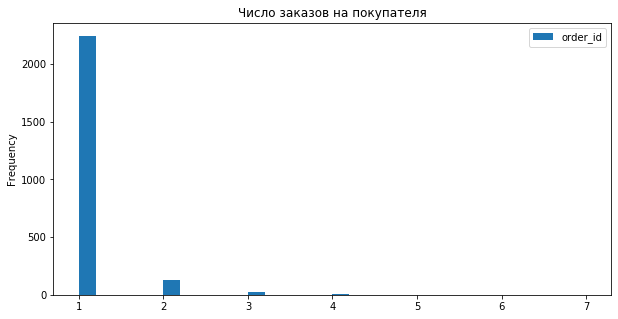

In [18]:
# число заказов на одного покупателя
(orders.groupby('customer_id')
    .agg({'order_id': 'nunique'})
    .plot(kind='hist',
          bins=30,
          title='Число заказов на покупателя', 
          figsize=(10,5)
         ))

Большенство клиентов не совершают повторных покупок.

In [19]:
# распределение заказов месяцам
print('Минимальная дата:',  
      orders['date'].min(), '\n'
      'Максимальная дата:', 
      orders['date'].max()
     )

Минимальная дата: 2018-10-01 00:00:00 
Максимальная дата: 2019-10-31 00:00:00


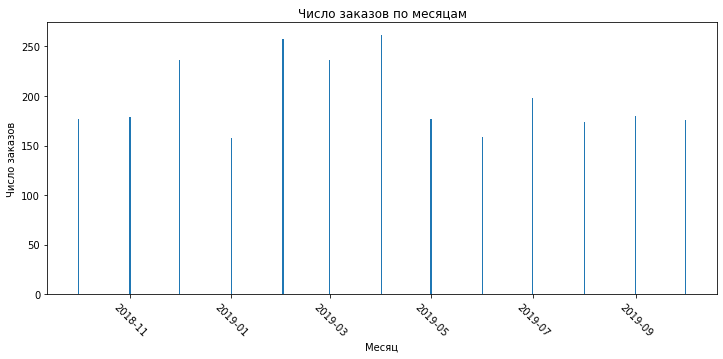

In [20]:
orders_by_month = orders.groupby('month').agg({'order_id': 'nunique'}).reset_index()
orders_by_month.columns = ['month', 'orders_count']

fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot()
ax.bar(orders_by_month['month'], orders_by_month['orders_count'])
ax.set(title='Число заказов по месяцам')

ax.set_ylabel('Число заказов')
ax.set_xlabel('Месяц')
plt.xticks(rotation=-45)
plt.show()

Выраженной сезонности в продажах нет, но сейчас анализируются общее число заказов без учета категорий товаров. Заметно увеличение продаж с февраля по апрель. Учитывая, что в данных по заказах есть много растений, то можно предположить, что сезонность есть, но в отдельных категориях товаров.

In [21]:
# распределение заказов по времени дня и по дням недели
orders['day'] = orders['date'].dt.dayofweek
orders['day_name'] = orders['date'].dt.day_name()
orders.head()

,date,customer_id,order_id,product,quantity,price,month,amount,day,day_name
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10-01,142.0,0,Monday
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018-10-01,194.0,0,Monday
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10-01,112.0,0,Monday
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10-01,179.0,0,Monday
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10-01,112.0,0,Monday


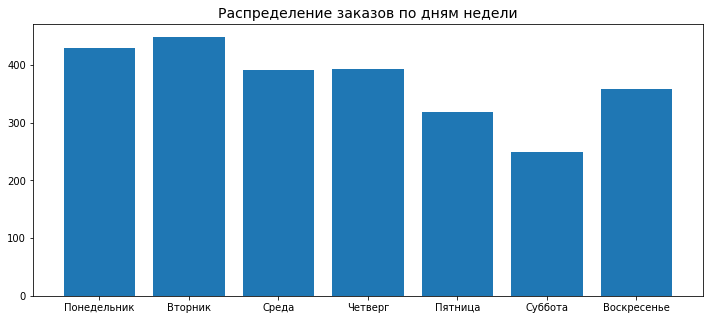

In [22]:
df = orders.groupby('day').agg({'order_id': 'nunique'}).reset_index()

plt.figure(figsize=(12,5))
plt.bar(df['day'], 
        df['order_id'], 
        tick_label=['Понедельник',
                    'Вторник',
                    'Среда',
                    'Четверг',
                    'Пятница',
                    'Суббота',
                    'Воскресенье']
       )
plt.title('Распределение заказов по дням недели', fontsize=14)
plt.show()

Есть небольшое сокращение заказов в пятницу - субботу, дней недели с резким ростом числа заказов также нет. Т.е. можно сделать вывод, что число заказов равномерно распределено по всем дням недели.  
Проверить распределение заказов внутри дня нет возможности, т.к. нет данных о времени совершения заказа.

In [23]:
# число товаров в заказе
df = orders.groupby('order_id').agg({'product': 'nunique'}).reset_index()

print('Число заказов с одним наименованием товара: ', 
      df.query('product == 1').shape[0], 
      '\n', 
      'в % от общего числа заказов: {:.2%}'.format(df.query('product == 1').shape[0] / df.shape[0])
     )

Число заказов с одним наименованием товара:  2183 
 в % от общего числа заказов: 85.34%


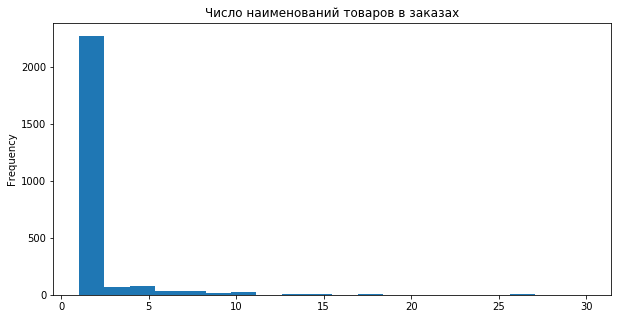

In [24]:
df['product'].plot(kind='hist',
          bins=20,
          title='Число наименований товаров в заказах', 
          figsize=(10,5)
         )

В более 85% заказов только одно наименование товара

In [25]:
# распределение заказов по среднему чеку
df = orders.groupby('order_id').agg({'amount': 'sum'}).reset_index()
df.describe()

,order_id,amount
count,2558.000000,2558.000000
mean,64366.752541,1129.915168
std,17980.988995,1754.557652
min,12624.000000,14.000000
25%,69173.500000,268.000000
50%,70573.500000,648.500000
75%,71906.000000,1349.000000
max,73162.000000,47385.000000


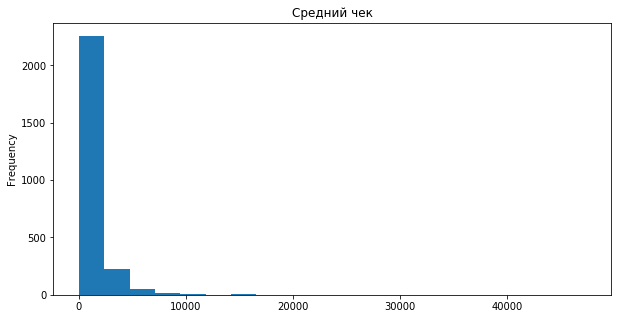

In [26]:
df['amount'].plot(kind='hist',
          bins=20,
          title='Средний чек', 
          figsize=(10,5)
         )

Большенство заказов - до 5000 рублей.

In [27]:
# определить top10 товаров - лидеров продаж
goods_top10 = orders.groupby('product').agg({'quantity': 'sum', 'amount': 'sum'})

print('Топ10 товаров по числу проданных единиц:')
print(goods_top10.sort_values(by='quantity', ascending=False).head(10))

print('Топ10 товаров по общей выручке:')
print(goods_top10.sort_values(by='amount', ascending=False).head(10))

Топ10 товаров по числу проданных единиц:
                                                    quantity   amount
product                                                              
Цветок искусственный Гвоздика пластиковая одино...        96   2007.0
Щетка-сметка 4-х рядная деревянная 300 мм (фигу...        90   5760.0
Ёрш унитазный с деревянной ручкой , Ваир 1712012          85   4616.0
Однолетнее растение Петуния махровая в кассете ...        80   6576.0
Пеларгония розебудная Red Pandora укорененный ч...        80  10788.0
Пеларгония зональная диам. 12 см красная махровая         63  10514.0
Муляж Красное яблоко мини полиуретан d-6 см               63   1242.0
Пеларгония розебудная Prins Nikolai укорененный...        63   8491.0
Пеларгония зональная диам. 12 см сиреневый полу...        62  10630.0
Тарелка суповая Luminarc ОКЕАН ЭКЛИПС 20,5 см L...        60   4680.0
Топ10 товаров по общей выручке:
                                                    quantity   amount
product          

__Сформируем список товарных категорий и проведем анализ с учетов категорий товаров__  
Классификация товаров по категориям придется делать вручную сгруппировав названия по первым словам. Лемматизацию, я думаю, не имеет смысла применять, т.к. будет еще больший список лем, которые нужно будет разбирать вручную. 

In [28]:
products = orders.loc[:,['product']]
products.drop_duplicates(inplace=True)
products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2149 entries, 0 to 6730
Data columns (total 1 columns):
product    2149 non-null object
dtypes: object(1)
memory usage: 33.6+ KB


В выборке по товарам 2149 уникальных товаров

Списки ключевых слов для классификации товаров на категории  
Я убрал код, которым смотрел категории товаров. В итоге все, все равно, свелось к ручному анализу списка. Смысла нет этот код оставлять тут. Автоматизированного способа выявления категорий я не придумал. Лемматизация и т.д., в итоге, также требуют ручного разбора списка ключевых слов.
Но результат получился хороший - товары разбились на категории практически без ошибок.

In [29]:
# растения
plants = ['Агератум', 'Адиантум', 'Азалия', 'Азалия', 'Аквилегия', 'Алиссум', 'Алоэ', 'Альбука', 'Амариллис', 'Анемона', 
          'Антуриум', 'Аптения', 'Арбуз', 'Аргирантерум', 'Артемизия', 'Аспарагус', 'Астра', 'Афеляндра', 'Бадан', 'Баклажан', 
          'Бакопа', 'Бальзамин', 'Бархатцы', 'Бегония', 'Буддлея', 'Бузульник', 'Валериана', 'Вербейник', 'Вербена', 'Вигна', 
          'Газания', 'Гайлардия', 'Гардения', 'Гвоздика', 'Георгина', 'Герань', 'Гербера', 'Гиацинт', 'Гимнокалициум', 
          'Гиностемма', 'Гипсофила', 'Глоксиния', 'Годеция', 'Горох', 'Гортензия', 'виноград', 'Декабрист', 'Дендробиум', 
          'Джункус', 'Диффенбахия', 'Драцена', 'Душица', 'Дыня', 'Ель', 'Завертка', 'Замиокулькас', 'Зверобой', 'Земляника', 
          'Змееголовник', 'Импатиенс', 'Кабачок', 'Каланхое', 'Калатея', 'Календула', 'Калибрахоа', 'Калла', 'Каллуна', 
          'Калоцефалус', 'Камнеломка', 'Кампанула', 'Капсикум', 'Капуста', 'Кипарисовик', 'Клен', 'Клубника', 'Кодонанта', 
          'Колеус', 'Колокольчик', 'Комнатное растение', 'Кореопсис', 'Космея', 'Кофе', 'Крассула', 'Лаванда', 'Лаватера', 
          'Лавр', 'Лантана', 'Лапчатка', 'Левкой', 'Лен', 'Лилейник', 'Литопс', 'Лобелия', 'Лук', 'Львиный зев', 'Любисток', 
          'Маттиола', 'Мединилла', 'Мелисса', 'Пеперомия', 'Шалфей', 'Мимоза', 'Мирт', 'Многолетнее растение', 'Молодило', 
          'Монарда', 'Морковь', 'Муррайя', 'Мускари', 'Виола', 'Крокусы', 'Мята', 'Настурция', 'Незабудка', 'Нивянник', 
          'Новогоднее дерево', 'Нолина', 'Овсянница', 'Огурец', 'Кориандр', 'Котовник', 'Однолетнее растение', 'Осина', 
          'Папоротник', 'Патиссон', 'Пахира', 'Пеларгония', 'Петрушка', 'Петуния', 'Вероника', 'Платикодон', 'Примула', 
          'Пряные травы', 'Пуансетия', 'Радермахера', 'Ранункулус', 'Роза', 'Розмарин', 'Рудбекия', 'Седум', 
          'Сельдерей', 'Синнингия', 'Смолевка', 'Соланум', 'Солидаго', 'Спатифиллум', 'Суккулент', 'Сциндапсус', 'Табак', 
          'Тимьян', 'Томат', 'Тыква', 'Тюльпан', 'Укроп', 'Фаленопсис', 'Фатсия', 'Фиалка', 'Физостегия', 'Фикус', 'Фиттония', 
          'Эхинацея', 'Флокс', 'Фуксия', 'Хамедорея', 'Хлорофитум', 'Хоста', 'Хризантема', 'Хризолидокарпус', 
          'Цветущее комнатное растение', 'Целозия', 'Цикламен', 'Цинерания', 'Циния', 'Циперус', 'Цитрофортунелла', 'Эвкалипт', 
          'Энотера', 'Цинерария', 'Цинния', 'Чабер', 'Эпипремнум', 'Эхеверия', 'Эхинокактус', 'Эшшольция', 'Юкка', 'Ясколка', 
          'томата', 'Шеффлера', 'Базилик', 'Пуансеттия', 'Подсолнечник', 'Салат']

In [30]:
# рассада
seedling = ['Рассада']

In [31]:
# для кухни
for_kitchen = ['Tepмокружка', 'Банка', 'Бидон', 'Блюдо', 'Блюдце', 'Бульонница', 'Ваза', 'Вакуумный пакет', 'Венчик', 'Вилка', 
               'Жестяная банка', 'Картофелемялка', 'Кастрюля', 'Ковш', 'Контейнер', 'Кружка', 'Кувшин', 'Ложка', 'Лопатка', 
               'Мантоварка', 'Мерный стакан', 'Миксер', 'Набор бокалов', 'Набор кружек', 'Набор ножей', 'Набор посуды', 
               'Набор стаканов', 'Набор столовых приборов', 'Набор форм', 'Набор фужеров', 'Нож', 'Ножеточка', 'Овощеварка', 
               'Овощечистка', 'Орехоколка', 'Подарочный набор', 'Подставка', 'Половник', 'Разделочная доска', 'Салфетка', 
               'Салфетница', 'Сахарница', 'Сито', 'Скалка', 'Скатерть', 'Сковорода', 'Соковарка', 'Соковыжималка', 'Сотейник', 
               'Тарелка', 'Терка', 'Термос', 'Термостакан', 'Толкушка', 'Тортница', 'Форма', 'Хлебница', 'ложка', 'Чайник', 
               'Чайный набор', 'Пресс для чеснока', 'Противень', 'Электроштопор', 'Кухонное полотенце', 
               'Набор кухонных полотенец', 'Набор махровых салфеток', 'Полотенце кухонное', 'Полотенце махровое', 
               'Полотенце прессованное', 'Нетканые салфетки','Шприц', 'Стеклянная крышка', 'Бензин', 'Доска разделочная', 
               'Пьезозажигалка', 'Масленка', 'Салатник', 'Просеиватель', 'Емкость для соуса', 
               'Рассекатель пламени на газовую плиту', 'Ополаскиватель для посудомоечных машин', 'Отделитель косточек', 
               'Крышка оцинкованная']

In [32]:
# для уборки
for_cleaning = ['Антижир', 'Антинакипин', 'Бальзам для мытья', 'Вантуз', 'Веник', 'Губка', 'мыло', 'Концентрат для мытья', 
                'Мешок для деликатной', 'Насадка','Окномойка', 'Отжим', 'Перчатки', 'Ролик для чистки', 'Скребок', 
                'Средство', 'Стиральный', 'Тряпка для кафеля', 'Чистящий', 'Швабра', 'Щетка', 'Окномойка', 'Паста для полировки', 
                'Сметка', 'Совок', 'швабра и ведро', 'Ведро', ' концентрированный гель', 'Тряпкодержатель', 'Ёрш', 'Ерш', 
                'Отбеливатель']

In [33]:
# средства хранения
for_storage = ['Емкость', 'Корзина', 'Корзинка', 'Коробка', 'Корыто', 'Котел', 'Кофр', 'Лоток', 'Миска', 'Таз', 'Ящик', 
               'коробка', 'Урна', 'Декоративная коробка', 'Бак для']

In [34]:
# для дома
for_home = ['Весы', 'Вешалка', 'Вкладыши', 'Гладильная', 'Ключница', 'Ковер', 'Коврик', 'Ковёр', 'Комод', 'Комплект махровых', 
            'Набор вешалок ', 'Набор ковров', 'сушилка', 'гладильная доска', 'Обувница', 'Плед', 'Плечики', 'кашпо', 
            'Подрукавник', 'Полк', 'Пылесос', 'Рукав', 'Сетка', 'пуф', 'Стеллаж', 'Сушилка', 'Термометр', 'Ткань', 'Утюг', 
            'Фоторамка', 'Чехол', 'Штора текстильная', 'Этажерка', 'Покрытие для гладильной', 'Сиденье для гладильной', 
            'Скребок для окон', 'Вешалки мягкие', ' гладильн', 'Подставка для обуви']

In [35]:
# искусственные растения
plants_dummy = ['Искусственн', 'Муляж', 'Декоративная']

In [36]:
# для ванной
for_bathroom = ['Ванна', 'Дозатор', 'соль', 'Зубная', 'Карниз', 'Кольца для штор', 'Комплект для ванной', 'Комплект для мытья', 
                'Махровое полотенц', 'полотенце мохровое' 'Мыльница', 'Основание для пробки', 'Пена', 'Подголовник', 
                'Пробка для ванны', 'Сиденье в ванну', 'Стакан', 'Увлажняющая маска', 'Штанга для ванной', 'Штора для ванной', 
                'Фен', 'Штора со встроенными','Махровый халат','Мыльница', 'Держатель для туалетной бумаги']

In [37]:
bags = ['сумка', 'тележ', 'Сумка для тележки']

In [38]:
# для спальни
for_bedroom = ['Наволочка', 'Наматрацник', 'Одеяло', 'Пододеяльник', 'Подушка', 'Покрывало', 'Простын']

In [39]:
# для ремонта
for_repair = ['Крепеж', 'Крючок', 'Лестница', 'Линейка', 'Набор инструментов', 'напильник', 'сверел', 'Петля', 'Сверло', 
              'Стремянк', 'Стяжка', 'Уголок', 'Фал капроновый', 'Фиксатор',  'сварка', 'Шило', 'Шнур', 'Штангенциркуль', 
              'Решетка вентиляционная', 'угольник', 'Шпагат полипропиленовый', 'Мешок для строительного мусора', 
              'Лестница-стремянка']

In [40]:
def define_category(ls, category):
    # список превращаем в строку чтобы использовать поиск по regexp
    words = [element.lower() for element in ls]
    words = '|'.join(words)
    
    products.loc[products['product'].str.lower().str.contains(words, regex=True), 'category'] = category

In [41]:
products['category'] = 'другое'
define_category(plants, 'растения')
define_category(seedling, 'рассада')
define_category(plants_dummy, 'искусственные растения')
define_category(for_bedroom, 'для спальни')
define_category(for_bathroom, 'для ванной')
define_category(for_home, 'для дома')
define_category(for_storage, 'упаковка и хранение')
define_category(for_cleaning, 'для уборки')
define_category(for_kitchen, 'для кухни')
define_category(bags, 'сумки и тележки')
define_category(for_repair, 'для ремонта')

In [42]:
# неразмеченные товары
products.query('category == "другое"').groupby('product').count()

,category
product,
"Сменный блок для ролика 2 шт (R160071), Rozenbal, R510100",1


В результате получились категории:
- растения
- рассада
- искусственные растения
- товары для дома
- товары для кухни
- товары для ванной
- товары для спальни
- товары для уборки
- упаковка и хранение
- сумки и тележки
- товары для ремонта

и... сменный блок для ролика... куда его девать не знаю, пусть лежит в неразмеченных товарах.

In [43]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4361 entries, 0 to 6734
Data columns (total 10 columns):
date           4361 non-null datetime64[ns]
customer_id    4361 non-null object
order_id       4361 non-null int64
product        4361 non-null object
quantity       4361 non-null int64
price          4361 non-null float64
month          4361 non-null datetime64[ns]
amount         4361 non-null float64
day            4361 non-null int64
day_name       4361 non-null object
dtypes: datetime64[ns](2), float64(2), int64(3), object(3)
memory usage: 374.8+ KB


In [44]:
# добавим категории в основной датасет
products = products.loc[:, ['product', 'category']]
orders = pd.merge(orders, products, on='product', how='left')

In [45]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4361 entries, 0 to 4360
Data columns (total 11 columns):
date           4361 non-null datetime64[ns]
customer_id    4361 non-null object
order_id       4361 non-null int64
product        4361 non-null object
quantity       4361 non-null int64
price          4361 non-null float64
month          4361 non-null datetime64[ns]
amount         4361 non-null float64
day            4361 non-null int64
day_name       4361 non-null object
category       4361 non-null object
dtypes: datetime64[ns](2), float64(2), int64(3), object(4)
memory usage: 408.8+ KB


In [46]:
orders.head()

,date,customer_id,order_id,product,quantity,price,month,amount,day,day_name,category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10-01,142.0,0,Monday,растения
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018-10-01,194.0,0,Monday,растения
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10-01,112.0,0,Monday,растения
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10-01,179.0,0,Monday,растения
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10-01,112.0,0,Monday,растения


__Распределение товаров по категориям__

In [47]:
def draw_bar(df1, df2, label):
    plt.figure(figsize=(12,5))
    plt.bar(df1, 
            df2
           )
    plt.xticks(rotation=-45)
    plt.title(label, fontsize=14)
    plt.show()

In [48]:
df = orders.groupby('category').agg({'product': 'nunique'}).reset_index()
df.columns = ['category', 'goods_count']
df.sort_values(by='goods_count', ascending=False, inplace=True)
df

,category,goods_count
9,растения,628
1,для дома,424
2,для кухни,311
8,рассада,207
7,искусственные растения,123
10,сумки и тележки,101
5,для уборки,93
0,для ванной,90
11,упаковка и хранение,88
3,для ремонта,69


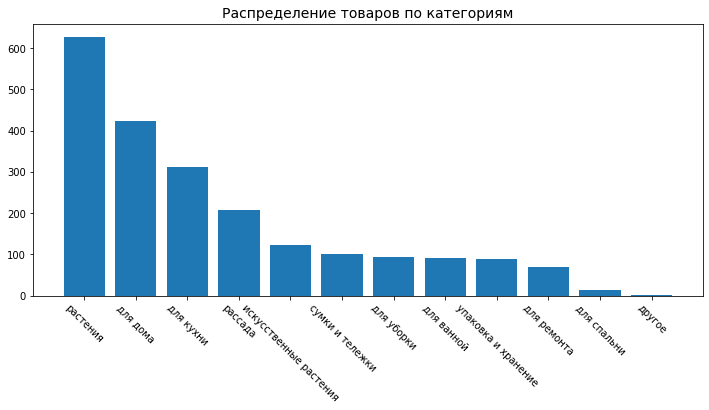

In [49]:
draw_bar(df['category'], 
         df['goods_count'], 
         'Распределение товаров по категориям'
        )

Максимальное число товаров в категориях:
- растения
- товары для дома
- товары для кухни
- рассада
- искусственные растения

__Определим top5 категорий товаров - лидеров продаж по числу покупок и общей стоимости__

In [50]:
df = orders.groupby('category').agg({'amount': 'sum', 'quantity': 'sum'}).reset_index()
df.columns = ['category', 'total_amount', 'total_items']
df.sort_values(by='total_amount', ascending=False, inplace=True)
df

,category,total_amount,total_items
1,для дома,890071.0,1235
10,сумки и тележки,619408.0,321
9,растения,352768.0,2467
2,для кухни,301961.0,992
11,упаковка и хранение,138262.0,216
3,для ремонта,120636.0,249
0,для ванной,114586.0,186
5,для уборки,112439.0,416
4,для спальни,91388.0,54
8,рассада,90416.0,756


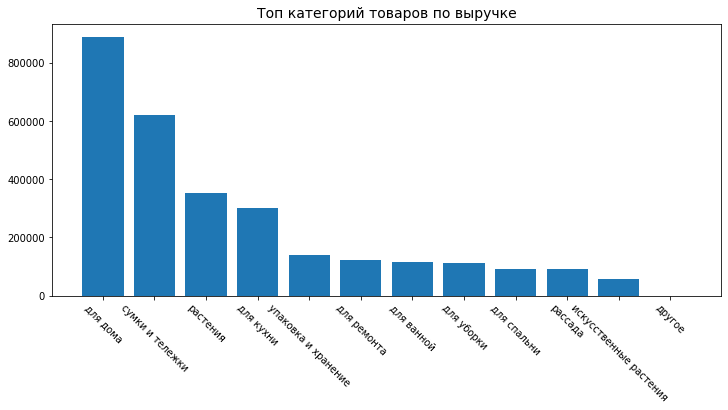

In [51]:
# Топ категорий по выручке
draw_bar(df['category'], 
         df['total_amount'], 
         'Топ категорий товаров по выручке'
        )

Наибольшую выручку приносят категории:
- для дома
- сумки и тележки
- растения	
- для кухни
- упаковка и хранение

In [52]:
df.sort_values(by='total_items', ascending=False, inplace=True)
df

,category,total_amount,total_items
9,растения,352768.0,2467
7,искусственные растения,58350.0,1245
1,для дома,890071.0,1235
2,для кухни,301961.0,992
8,рассада,90416.0,756
5,для уборки,112439.0,416
10,сумки и тележки,619408.0,321
3,для ремонта,120636.0,249
11,упаковка и хранение,138262.0,216
0,для ванной,114586.0,186


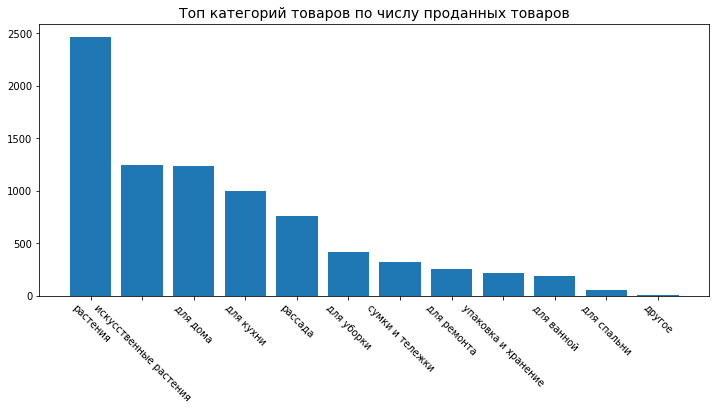

In [53]:
# Топ категорий по выручке
draw_bar(df['category'], 
         df['total_items'], 
         'Топ категорий товаров по числу проданных товаров'
        )

При этом лидеры по числу проданных единиц товара:
- растения
- искусственные растения
- товары для дома
- товары для кухни
- рассада

Искусственные растения явно лишние в этом списке. Продаж много, выручки минимум. 

__Средний чек по категориям__

In [54]:
df = orders.groupby(['order_id', 'category']).agg({'amount': 'sum'}).reset_index()
df = df.groupby('category').agg({'amount': 'mean'}).reset_index()
df.sort_values(by='amount', ascending=False, inplace=True)
df

,category,amount
4,для спальни,6092.533333
10,сумки и тележки,1998.090323
3,для ремонта,1566.701299
1,для дома,1344.518127
11,упаковка и хранение,1191.913793
5,для уборки,1041.101852
0,для ванной,954.883333
2,для кухни,952.558360
8,рассада,706.375000
9,растения,534.496970


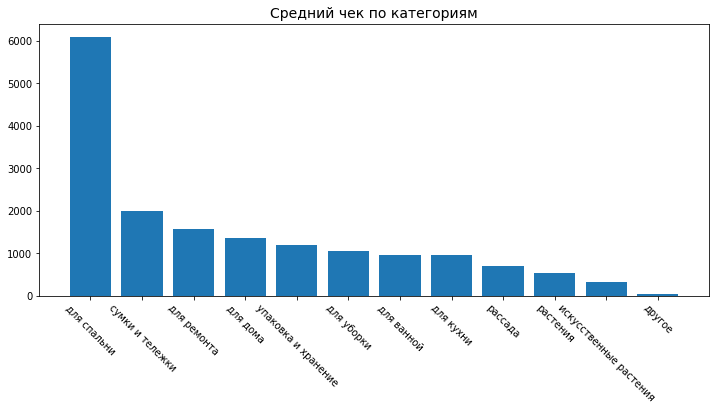

In [55]:
draw_bar(df['category'], 
         df['amount'], 
         'Средний чек по категориям'
        )

__Сезонность продаж с учетом категорий товаров__  
Проверим сезонность для отдельных категорий, которые приносят наибольшую выручку. Предполагаю, что есть сезонность в категориях Рассада и Растения, в остальных категориях сезонности нет.

In [56]:
def check_seasons(category_name):
    df = (orders.query('category == @category_name')
                .groupby('month')
                .agg({'quantity': 'sum'})
                .reset_index()
                .sort_values(by='month')
         )

    plt.figure(figsize=(12,5))
    plt.bar(df['month'], 
            df['quantity']
           )
    plt.title('Продажи по месяцам в категории - ' + category_name)
    plt.show()

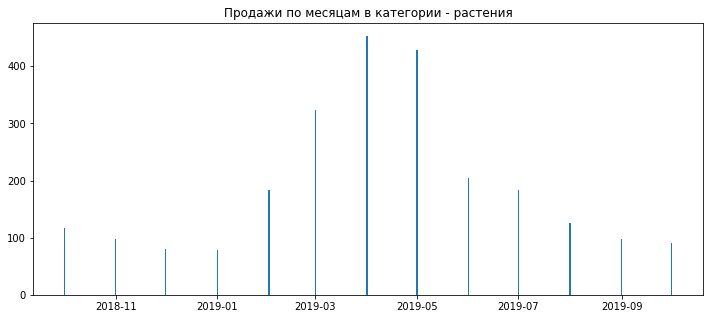

In [57]:
check_seasons('растения')

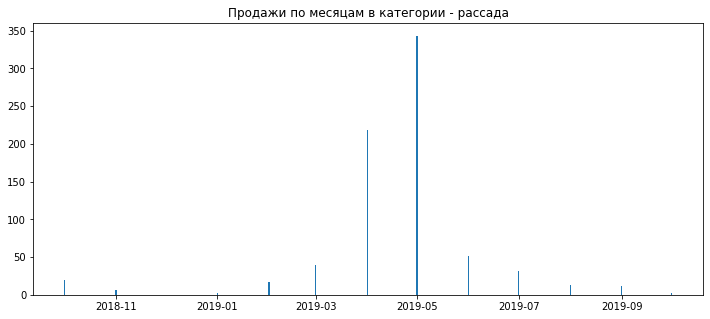

In [58]:
check_seasons('рассада')

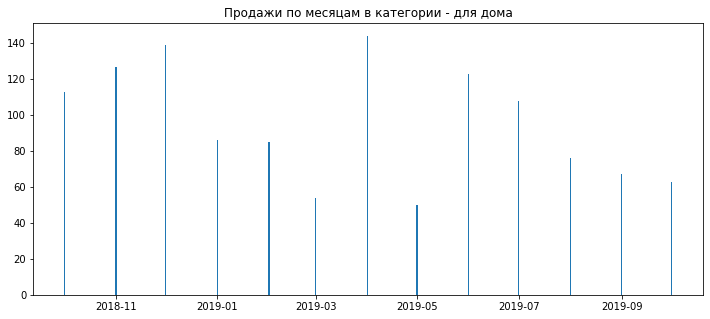

In [59]:
check_seasons('для дома')

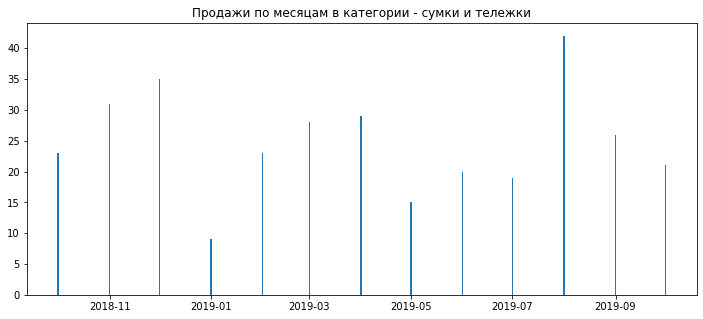

In [60]:
check_seasons('сумки и тележки')

Сезонность продаж есть в категориях Растения и Рассада.

### Выводы
В исследовательском анализе нужно было ответить на вопросы:
- Определить, характерны ли повторные покупки для покупателей - нет, повторные покупки не характерны. Большенство покупателей совершают только один заказ.
- Определить, есть ли сезонность в продаже товаров. Если рассматривать продажи в целом без учета категорий товаров, то сезонности нет. Но если учитывать категории товаров, то сезонность есть в категориях Растения и Рассада - весной продажи заметно растут.
- Определить, есть ли пиковые дни продаж - нет, таких дней нет. Заказы равномерно распределены по всем дням недели.
- Определить число товаров в заказе - в большенстве заказов всего один товар
- Средний чек - 1130 руб. При этом 75% заказов с чеком до 1350 руб
- Определить top10 товаров - лидеров продаж. Выборка см. выше.

По данным заказов сформированы товарные категории:
- растения
- рассада
- искусственные растения
- товары для дома
- товары для кухни
- товары для ванной
- товары для спальни
- товары для уборки
- упаковка и хранение
- сумки и тележки
- товары для ремонта

Максимальное число товаров в категориях:
- растения
- товары для дома
- товары для кухни
- рассада
- искусственные растения

Наибольшую выручку приносят категории:
- для дома
- сумки и тележки
- растения	
- для кухни
- упаковка и хранение

При этом лидеры по числу проданных единиц товара:
- растения
- искусственные растения
- товары для дома
- товары для кухни
- рассада

Искусственные растения явно лишние в этом списке. Продаж много, выручки минимум. 

<a id='segments'></a>
### 3. Сегментация покупателей
Цель шага - сделать сегментацию покупателей по различным признакам для дальнейшего использования в маркетинговых активностях.

Выделить сегменты покупателей:
- по числу заказов на одного покупателя. Маркетинг сможет использовать сегменты для повышения LTV.
- по категориям товаров. Может использоваться для персонализированных рекламных рассылок только по интересным для покупателям категориям
- по среднему чеку. Может использоваться для персонализированных рекламных рассылок в заданном ценовом диапазоне.
- по давности последнего заказа. Маркетинговые рассылки для клиентов, которые давно не покупали. Например, с предложением скидки, с целью вернуть клиента в магазин.

__Построим матрицу признаков для покупателей__

In [61]:
orders.head()

,date,customer_id,order_id,product,quantity,price,month,amount,day,day_name,category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10-01,142.0,0,Monday,растения
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018-10-01,194.0,0,Monday,растения
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10-01,112.0,0,Monday,растения
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10-01,179.0,0,Monday,растения
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10-01,112.0,0,Monday,растения


In [62]:
# сначала сгруппируем данные по заказам
orders_grouped = orders.groupby(['customer_id',
                                 'order_id']
                               ).agg({'quantity': 'sum', 
                                      'amount': 'sum'}
                                    ).reset_index()

orders_grouped.columns = ['customer_id', 'order_id', 'items_count', 'total_amount']

# ср. число товаров в заказе, общая стоимость всех заказов, ср. стоимость заказа
orders_grouped = orders_grouped.groupby('customer_id').agg({'items_count': 'mean', 
                                                            'total_amount':['sum', 'mean']}
                                                          ).reset_index()

orders_grouped.columns = ['customer_id', 'avg_items', 'orders_total_amount', 'orders_avg_amount']
orders_grouped.head()

,customer_id,avg_items,orders_total_amount,orders_avg_amount
0,000d6849-084e-4d9f-ac03-37174eaf60c4,4.0,555.0,555.0
1,001cee7f-0b29-4716-b202-0042213ab038,1.0,442.0,442.0
2,00299f34-5385-4d13-9aea-c80b81658e1b,2.0,914.0,914.0
3,002d4d3a-4a59-406b-86ec-c3314357e498,1.0,1649.0,1649.0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2.0,2324.0,2324.0


In [63]:
customers = orders.groupby('customer_id').agg({'order_id': 'nunique', 'category': 'nunique', 'date': 'max'}).reset_index()
customers.columns = ['customer_id', 'orders', 'category', 'last_order_date']
customers.head()

,customer_id,orders,category,last_order_date
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,1,2019-10-16
1,001cee7f-0b29-4716-b202-0042213ab038,1,1,2019-02-16
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,1,2019-10-14
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1,2019-01-27
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,1,2019-09-29


In [64]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 4 columns):
customer_id        2400 non-null object
orders             2400 non-null int64
category           2400 non-null int64
last_order_date    2400 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 75.1+ KB


In [65]:
orders_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 4 columns):
customer_id            2400 non-null object
avg_items              2400 non-null float64
orders_total_amount    2400 non-null float64
orders_avg_amount      2400 non-null float64
dtypes: float64(3), object(1)
memory usage: 75.1+ KB


In [66]:
customers = pd.merge(customers, orders_grouped, on='customer_id')
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2400 entries, 0 to 2399
Data columns (total 7 columns):
customer_id            2400 non-null object
orders                 2400 non-null int64
category               2400 non-null int64
last_order_date        2400 non-null datetime64[ns]
avg_items              2400 non-null float64
orders_total_amount    2400 non-null float64
orders_avg_amount      2400 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 150.0+ KB


In [67]:
customers.head()

,customer_id,orders,category,last_order_date,avg_items,orders_total_amount,orders_avg_amount
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,1,2019-10-16,4.0,555.0,555.0
1,001cee7f-0b29-4716-b202-0042213ab038,1,1,2019-02-16,1.0,442.0,442.0
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,1,2019-10-14,2.0,914.0,914.0
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1,2019-01-27,1.0,1649.0,1649.0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,1,2019-09-29,2.0,2324.0,2324.0


In [68]:
# посчитаем число дней с даты последнего заказа

# за точку отсчета берем макс. дату заказа + 1 день
max_date = orders['date'].max() + pd.Timedelta('1d')

customers ['no_order_days'] = customers['last_order_date'].apply(lambda x: (max_date - x).days)
# ненужный столбец удаляем
customers.drop(['last_order_date'], axis=1, inplace=True)
customers.head()

,customer_id,orders,category,avg_items,orders_total_amount,orders_avg_amount,no_order_days
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,1,4.0,555.0,555.0,16
1,001cee7f-0b29-4716-b202-0042213ab038,1,1,1.0,442.0,442.0,258
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,1,2.0,914.0,914.0,18
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1,1.0,1649.0,1649.0,278
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,1,2.0,2324.0,2324.0,33


In [69]:
customers.describe()

,orders,category,avg_items,orders_total_amount,orders_avg_amount,no_order_days
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,1.077917,1.065000,3.080263,1204.301250,1114.674906,204.573333
std,0.330743,0.298572,4.834733,1990.758951,1540.709818,110.643958
min,1.000000,1.000000,1.000000,14.000000,14.000000,1.000000
25%,1.000000,1.000000,1.000000,296.000000,276.875000,110.000000
50%,1.000000,1.000000,1.000000,675.500000,652.000000,212.000000
75%,1.000000,1.000000,2.000000,1481.500000,1349.250000,295.000000
max,7.000000,5.000000,30.000000,53232.000000,26616.000000,396.000000


__Посмотрим на распределения признаков клиентов__

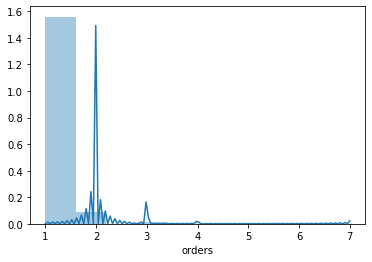

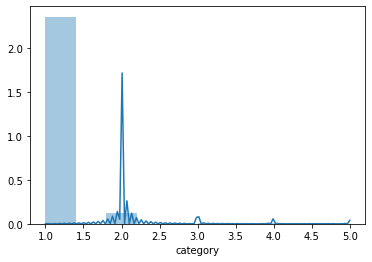

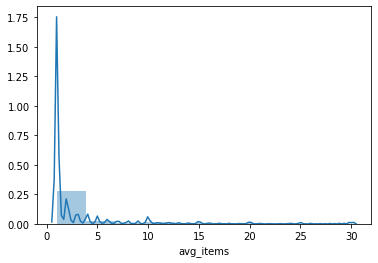

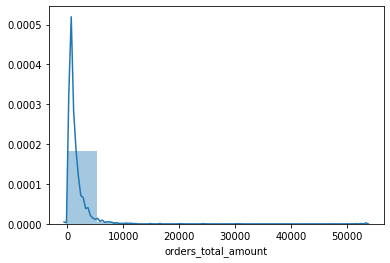

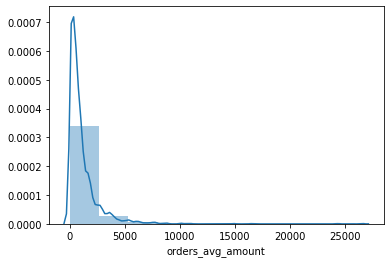

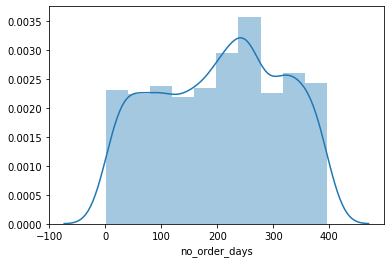

In [70]:
for col in customers.drop(['customer_id'], axis=1).columns:
  sns.distplot(customers[col], bins = 10)
  plt.show()

Распределения признаков ничего нового о поведении покупателях не показали, выше эти выводы уже сделаны. Добавился новый показатель - число дней с последнего заказа. Видно, что признак распределен нормально.

__Построим тепловую карту для корреляции признаков__

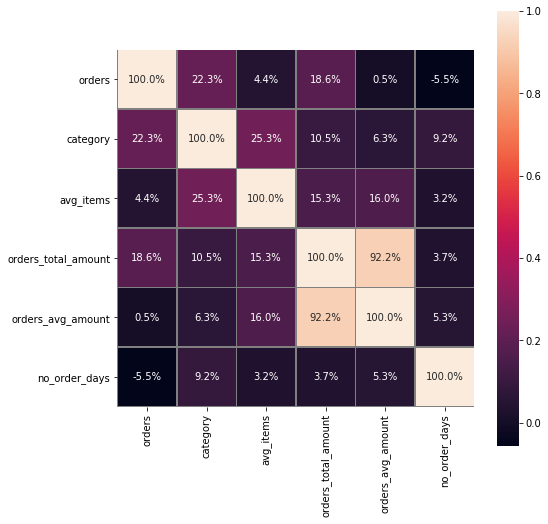

In [71]:
#построим и отрисуем матрицу корреляций
cm = customers.drop(['customer_id'], axis=1).corr()
fig = plt.figure(figsize=(8,8))
# тепловая карта для матрицы корреляций
sns.heatmap(cm, 
            annot=True, 
            square=True,
            linewidths=.5, 
            linecolor='gray',
            fmt='.1%'
           )

# фикс кривизны отрисовки карты
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)

plt.show()

Взаимосвязи можно выявить по тепловой карте:
- кол-во категорий, в которых покупатель выбирал товары, связано с числом заказов на покупателя
- ср. число товаров в заказе связано с общей стоимостью заказов
- ср. чек связан с общей суммой по заказам. Т.к. тут связь сильная, то один из параметров стоит исключить из дальнейшего рассмотрения.

In [72]:
# уберем orders_total_amount из матрицы признаков
customers.drop(['orders_total_amount'], axis=1, inplace=True)

__Сделаем кластеризацию покупателей с использованием машинного обучения. Предварительно построим дендрограмму и выберем оптимальное число кластеров__

In [73]:
# стандартизируем данные 
scaler = StandardScaler()
X_sc = scaler.fit_transform(customers.drop(columns = ['customer_id']))

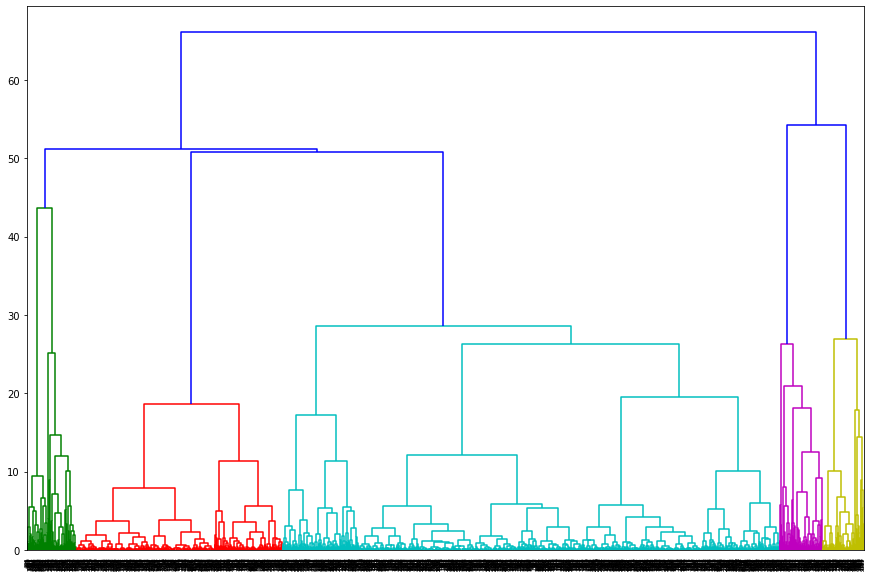

In [74]:
# дендрограмма
linked = linkage(X_sc, method = 'ward')

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

In [75]:
# прогнозирование кластеров покупателей
km = KMeans(n_clusters = 3, random_state = 0) # задаём число кластеров, равное 3
labels = km.fit_predict(X_sc)

Пробовал задавать разное число кластеров, но при значениях 5 и больше уже непонятно, чем кластеры отличаются друг от друга и, соответственно, будет непонятно как для таких кластеров делать персонализированные предложения и маркетинг.  
Поэтому было выбрано число кластеров = 3.

In [76]:
customers['cluster'] = labels
customers.head()

,customer_id,orders,category,avg_items,orders_avg_amount,no_order_days,cluster
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,1,4.0,555.0,16,0
1,001cee7f-0b29-4716-b202-0042213ab038,1,1,1.0,442.0,258,0
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,1,2.0,914.0,18,0
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1,1.0,1649.0,278,0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,1,2.0,2324.0,33,0


__Сравним средние значения признаков по кластерам__

In [77]:
customers.groupby('cluster').mean()

,orders,category,avg_items,orders_avg_amount,no_order_days
cluster,,,,,
0,1.000000,1.000000,1.901808,1011.985833,203.851490
1,1.034146,1.575610,14.958537,2259.409756,231.160976
2,2.216216,1.256757,2.926560,949.363337,177.729730


Выделено 3 кластера, которые различаются: 
- по числу заказов
- по среднему чеку
- по числу дней с последнего заказа

По этим кластерам покупателей можно строить маркетинговые активности для повышения LTV, ср. чек, реактивации покупателей.

__Проверим наличие связей между категориями товаров__

In [78]:
# посчитаем в каких категориях и сколько товаров купил каждый покупатель
category = orders.groupby(['customer_id', 'category']).agg({'quantity': 'sum'}).reset_index()
category.columns = ['customer_id', 'category_name', 'items_count']
category.head()

,customer_id,category_name,items_count
0,000d6849-084e-4d9f-ac03-37174eaf60c4,растения,4
1,001cee7f-0b29-4716-b202-0042213ab038,для дома,1
2,00299f34-5385-4d13-9aea-c80b81658e1b,для дома,2
3,002d4d3a-4a59-406b-86ec-c3314357e498,сумки и тележки,1
4,003bbd39-0000-41ff-b7f9-2ddaec152037,для дома,2


In [79]:
category_matrix = category.pivot_table(index = 'customer_id', 
                                       columns = 'category_name', 
                                       values='items_count', 
                                       aggfunc='sum')
category_matrix.fillna(0, inplace=True)
category_matrix.head()

category_name,для ванной,для дома,для кухни,для ремонта,для спальни,для уборки,другое,искусственные растения,рассада,растения,сумки и тележки,упаковка и хранение
customer_id,,,,,,,,,,,,
000d6849-084e-4d9f-ac03-37174eaf60c4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
001cee7f-0b29-4716-b202-0042213ab038,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00299f34-5385-4d13-9aea-c80b81658e1b,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
002d4d3a-4a59-406b-86ec-c3314357e498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
003bbd39-0000-41ff-b7f9-2ddaec152037,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
category_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2400 entries, 000d6849-084e-4d9f-ac03-37174eaf60c4 to ffe82299-3f5b-4214-87fe-3d36ecccfac3
Data columns (total 12 columns):
для ванной                2400 non-null float64
для дома                  2400 non-null float64
для кухни                 2400 non-null float64
для ремонта               2400 non-null float64
для спальни               2400 non-null float64
для уборки                2400 non-null float64
другое                    2400 non-null float64
искусственные растения    2400 non-null float64
рассада                   2400 non-null float64
растения                  2400 non-null float64
сумки и тележки           2400 non-null float64
упаковка и хранение       2400 non-null float64
dtypes: float64(12)
memory usage: 243.8+ KB


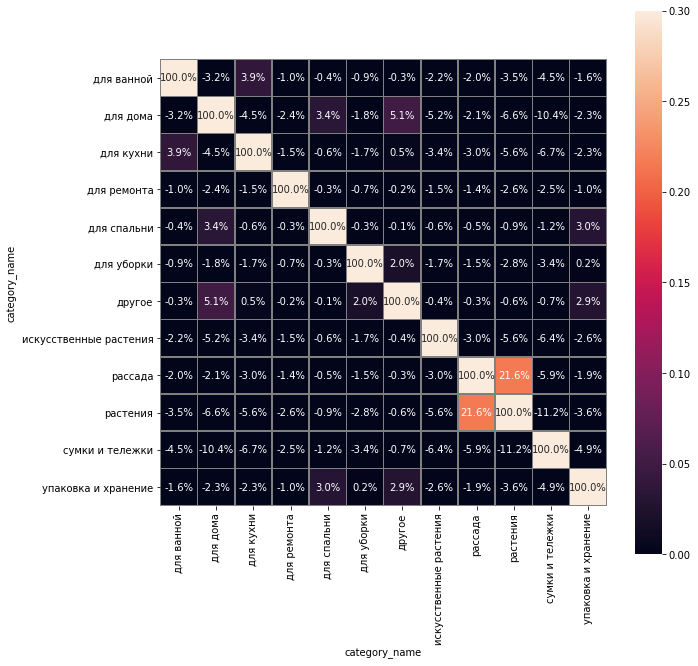

In [81]:
#построим и отрисуем матрицу корреляций
cm = category_matrix.corr()
fig = plt.figure(figsize=(10,10))
# тепловая карта для матрицы корреляций
sns.heatmap(cm, 
            annot=True, 
            square=True,
            linewidths=.5, 
            linecolor='gray',
            vmin=0,
            vmax=0.3,
            fmt='.1%'
           )

# фикс кривизны отрисовки карты
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)

plt.show()

Можно сделать вывод, что корреляция существует для категорий товаров:
- Растения и рассада
- слабая между Товары для дома и Тележки

Внедрение рекомендательной системы должно, в первую очередь, исправить эту картину. Если покупателям будут показываться товары из связанных категорий, то должно увеличиться число заказов с товарами из рахных категорий, увеличится ср. чек.

Матрица category_matrix может использоваться для формирования персонализированных предложений клиентах на основе категорий их прошлых покупок.

### Вывод
- сформирована матрица признаков покупателей, проверены распределения и зависимости между признаками. Распределения признаков подтвердили выводы про число повторных покупок, ср. чек и т.д. сделаные ранее
- с помощью методов машинного обучения выполнена кластеризация покупателей, выделены 3 сегмента, которые затем могут использоваться в маркетинговых активностях.
- выявлены связи между категориями товаров. Хотя и большенство покупателей покупают товары только из одной категории, существует взаимосвязь между категоряими Растения и Рассада

<a id='ideas'></a>
### 4. Проверка гипотез
Цель шага - проверить гипотезы и сформулировать на основе них рекомендации.

Проверить гипотезы:
- большенство покупателей делают только один заказ. Сделать вывод о необходимости дальнейшего анализа причин низкого LTV.
- большенство покупателей покупают товары из одной категории. Сделать вывод о формировании персонализированных рекомендаций покупателям.

__Проверка гипотезы: большенство покупателей делают только один заказ__

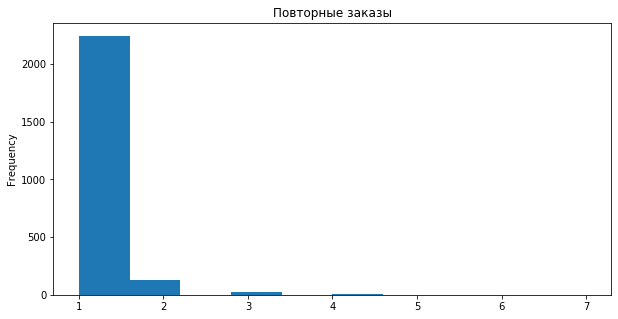

In [82]:
customers['orders'].plot(kind='hist',
          bins=10,
          title='Повторные заказы', 
          figsize=(10,5)
         )

In [83]:
print('Число покупателей с одним заказом:', 
      customers.query('orders == 1').shape[0],
      '\n',
      'в % от общего числа покупателей: {:.2%}'.format(customers.query('orders == 1').shape[0] / customers.shape[0]), 
      '\n'
     )

Число покупателей с одним заказом: 2245 
 в % от общего числа покупателей: 93.54% 



Можно сделать вывод, что более 93% покупателей сделали только один заказ. Необходимо проводить анализ поведения покупателей, выявлять причины отсутствия повторных покупок. Повышение LTV - это сильная точка роста выручки этого магазина. 

__Проверка гипотезы: большенство покупателей покупают товары из одной категории__

In [84]:
df = orders.groupby('customer_id').agg({'category': 'nunique'}).reset_index()

print('Покупатели с товарами из одной категории:', 
      df.query('category == 1').shape[0], 
      '\n',
      'в % от общего числа покупателей: {:.2%}'.format(df.query('category == 1').shape[0] / df.shape[0])
     )

Покупатели с товарами из одной категории: 2268 
 в % от общего числа покупателей: 94.50%


Аналогичная ситуация - более 94% покупателей покупают товары только из одной категории.

### Вывод
Обе гипотезы подтвердились:
- более 93% покупателей сделали только один заказ
- более 94% покупателей покупают товары только из одной категории

статистические методы проверки гипотез не применялись, нет смысла.

<a id='recomendations'></a>
## Выводы и рекомендации

### Презентация
https://drive.google.com/file/d/1lcg2x-bqpwJHxRHTigu3zKcKaFz3SfxE/view?usp=sharing

### Профили потребления
Из анализа данных по заказам выявлены следующие особенности поведения покупателей:
- более 93% покупателей сделали только один заказ. Одиночные заказы - это норма поведения покупателей, повторные заказы, в данном случае, исключительная ситуация. LTV клиентов не будет высоким в этом случае.
- в более 85% заказов только одно наименование товара. Это может говорить о том, что нет рекомендательной системы или система поиска товаров сложная или неудобная. Покупатель ищет конкретный товар и ему не предлагаются связанные или дополнительные товары.
- в продажах товаров категорий Растения и Рассада есть сезонность - весной продажи заметно растут.
- дней с повышенным числом заказов не выявлено. Заказы равномерно распределены по всем дням недели.
- средний чек - 1130 руб. При этом 75% заказов с чеком до 1350 руб.

Максимальное число товаров в категориях:
- растения
- товары для дома
- товары для кухни
- рассада
- искусственные растения

Наибольшую выручку приносят категории:
- для дома
- сумки и тележки
- растения	
- для кухни
- упаковка и хранение

При этом лидеры по числу проданных единиц товара:
- растения
- искусственные растения
- товары для дома
- товары для кухни
- рассада

### Сегменты покупателей
С помощью методов машинного обучения выполнена кластеризация покупателей выделены 3 сегмента, которые различаются: 
- по числу заказов
- по среднему чеку
- по числу дней с последнего заказа
По этим кластерам покупателей можно строить маркетинговые активности для повышения LTV, ср. чек, реактивации покупателей.

Выявлены связи между категориями товаров. Хотя и большенство покупателей покупают товары только из одной категории, существует взаимосвязь между категоряими Растения и Рассада

### Рекомендации
- выполнить дополнительный анализ поведения покупателей, выявить причины низкого числа повторных покупок. Увеличение LTV приведет к росту выручки магазина.
- внедрить рекомендательную систему, проанализировать структуру каталога, навигацию, поиск и т.д. влияющие на поведение клиента при поиске товары. Клиенты выбирают один товар из одной категории - это плохой показатель и это сказывается на низком ср. чеке и ср. выручке заказа.
- формировать персонализированные предложения на основе сформированных сегментов покупателей.